# DỰ ĐOÁN HIỆU SUẤT XE HƠI

In [100]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 26.8MB/s]


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [102]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [104]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [105]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [106]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [107]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [108]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [109]:

batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)


In [110]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [111]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)


In [112]:
lr = 1e-2
criterion = nn. MSELoss ()
optimizer = torch . optim . SGD ( model . parameters () , lr=lr)

In [113]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [114]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    val_target = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')



EPOCH 1:	Training loss: 282.769	Validation loss: 88.672

EPOCH 2:	Training loss: 137.669	Validation loss: 72.346

EPOCH 3:	Training loss: 71.007	Validation loss: 19.143

EPOCH 4:	Training loss: 25.083	Validation loss: 196.176

EPOCH 5:	Training loss: 96.139	Validation loss: 20.444

EPOCH 6:	Training loss: 17.765	Validation loss: 9.444

EPOCH 7:	Training loss: 18.486	Validation loss: 14.535

EPOCH 8:	Training loss: 37.859	Validation loss: 37.427

EPOCH 9:	Training loss: 17.133	Validation loss: 38.134

EPOCH 10:	Training loss: 22.991	Validation loss: 41.183

EPOCH 11:	Training loss: 26.723	Validation loss: 20.063

EPOCH 12:	Training loss: 9.852	Validation loss: 5.594

EPOCH 13:	Training loss: 15.143	Validation loss: 16.025

EPOCH 14:	Training loss: 12.213	Validation loss: 12.023

EPOCH 15:	Training loss: 14.222	Validation loss: 7.731

EPOCH 16:	Training loss: 10.845	Validation loss: 18.904

EPOCH 17:	Training loss: 12.312	Validation loss: 14.885

EPOCH 18:	Training loss: 15.474	Validati

In [115]:
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'R2: {test_set_r2}')


Evaluation on test set:
R2: 0.8417800068855286


# Phân loại với dữ liệu phi tuyến

In [116]:
! gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 15.2MB/s]


In [117]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [118]:
# Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Đọc bộ dữ liệu
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

print(X.shape, y.shape)


(300, 2) (300,)


In [119]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Chuẩn hóa đặc trưng đầu vào
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [120]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)


In [121]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)


In [122]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy


In [123]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')



EPOCH 1:	Training loss: 0.939	Validation loss: 0.864

EPOCH 2:	Training loss: 0.750	Validation loss: 0.815

EPOCH 3:	Training loss: 0.715	Validation loss: 0.799

EPOCH 4:	Training loss: 0.689	Validation loss: 0.791

EPOCH 5:	Training loss: 0.670	Validation loss: 0.780

EPOCH 6:	Training loss: 0.654	Validation loss: 0.747

EPOCH 7:	Training loss: 0.646	Validation loss: 0.724

EPOCH 8:	Training loss: 0.616	Validation loss: 0.704

EPOCH 9:	Training loss: 0.616	Validation loss: 0.694

EPOCH 10:	Training loss: 0.610	Validation loss: 0.666

EPOCH 11:	Training loss: 0.577	Validation loss: 0.666

EPOCH 12:	Training loss: 0.596	Validation loss: 0.642

EPOCH 13:	Training loss: 0.556	Validation loss: 0.625

EPOCH 14:	Training loss: 0.537	Validation loss: 0.608

EPOCH 15:	Training loss: 0.521	Validation loss: 0.604

EPOCH 16:	Training loss: 0.530	Validation loss: 0.587

EPOCH 17:	Training loss: 0.511	Validation loss: 0.566

EPOCH 18:	Training loss: 0.498	Validation loss: 0.569

EPOCH 19:	Training

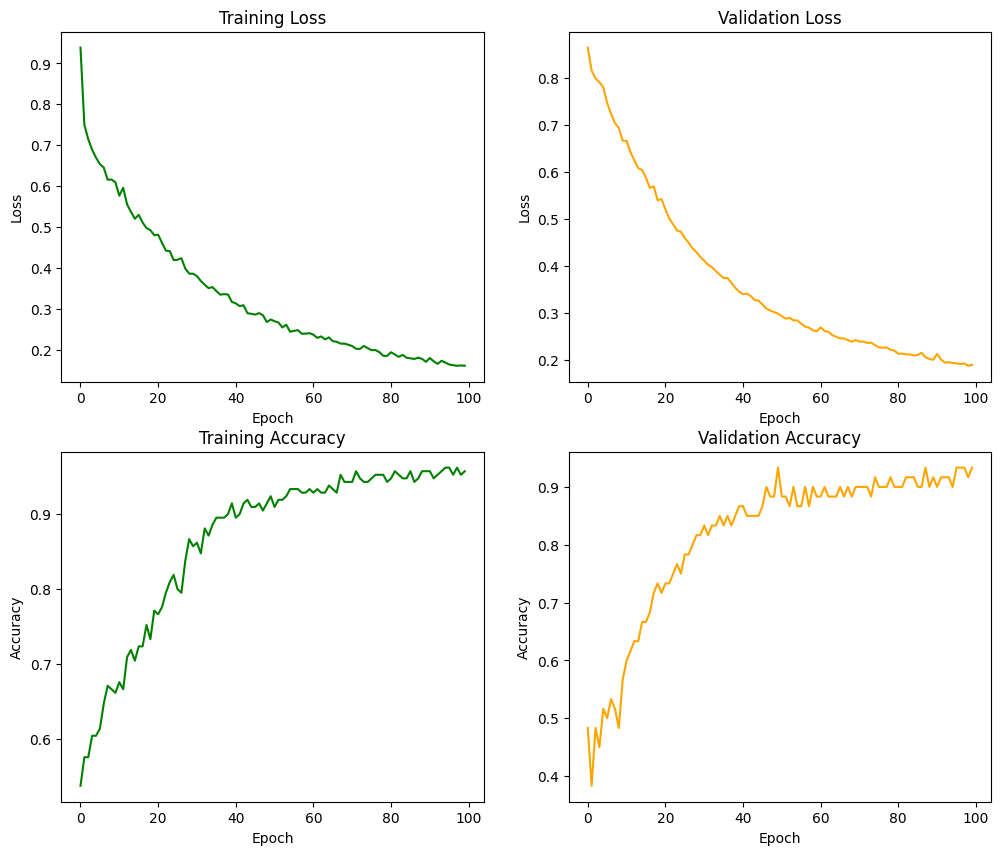

In [124]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


In [125]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')


Evaluation on test set:
Accuracy: 0.9333333333333333


# Phân loại cảm xúc trên ảnh

In [126]:
! gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=7f77d40c-da54-45af-b478-7634fbf11c58
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 163MB/s]


In [127]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [128]:
import zipfile

# Đường dẫn tệp zip
zip_path = '/content/FER-2013.zip'

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')


In [129]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')


Image height: 128
Image width: 128


In [130]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx,
                 split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)
        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label


batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)


In [131]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)


In [132]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

# Huấn luyện mô hình
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')



EPOCH 1:	Training loss: 1.917	Validation loss: 1.882

EPOCH 2:	Training loss: 1.849	Validation loss: 1.828

EPOCH 3:	Training loss: 1.811	Validation loss: 1.802

EPOCH 4:	Training loss: 1.790	Validation loss: 1.785

EPOCH 5:	Training loss: 1.773	Validation loss: 1.770

EPOCH 6:	Training loss: 1.757	Validation loss: 1.754

EPOCH 7:	Training loss: 1.739	Validation loss: 1.736

EPOCH 8:	Training loss: 1.719	Validation loss: 1.715

EPOCH 9:	Training loss: 1.697	Validation loss: 1.695

EPOCH 10:	Training loss: 1.676	Validation loss: 1.677

EPOCH 11:	Training loss: 1.659	Validation loss: 1.665

EPOCH 12:	Training loss: 1.645	Validation loss: 1.654

EPOCH 13:	Training loss: 1.634	Validation loss: 1.644

EPOCH 14:	Training loss: 1.623	Validation loss: 1.638

EPOCH 15:	Training loss: 1.613	Validation loss: 1.631

EPOCH 16:	Training loss: 1.604	Validation loss: 1.623

EPOCH 17:	Training loss: 1.596	Validation loss: 1.618

EPOCH 18:	Training loss: 1.587	Validation loss: 1.620

EPOCH 19:	Training

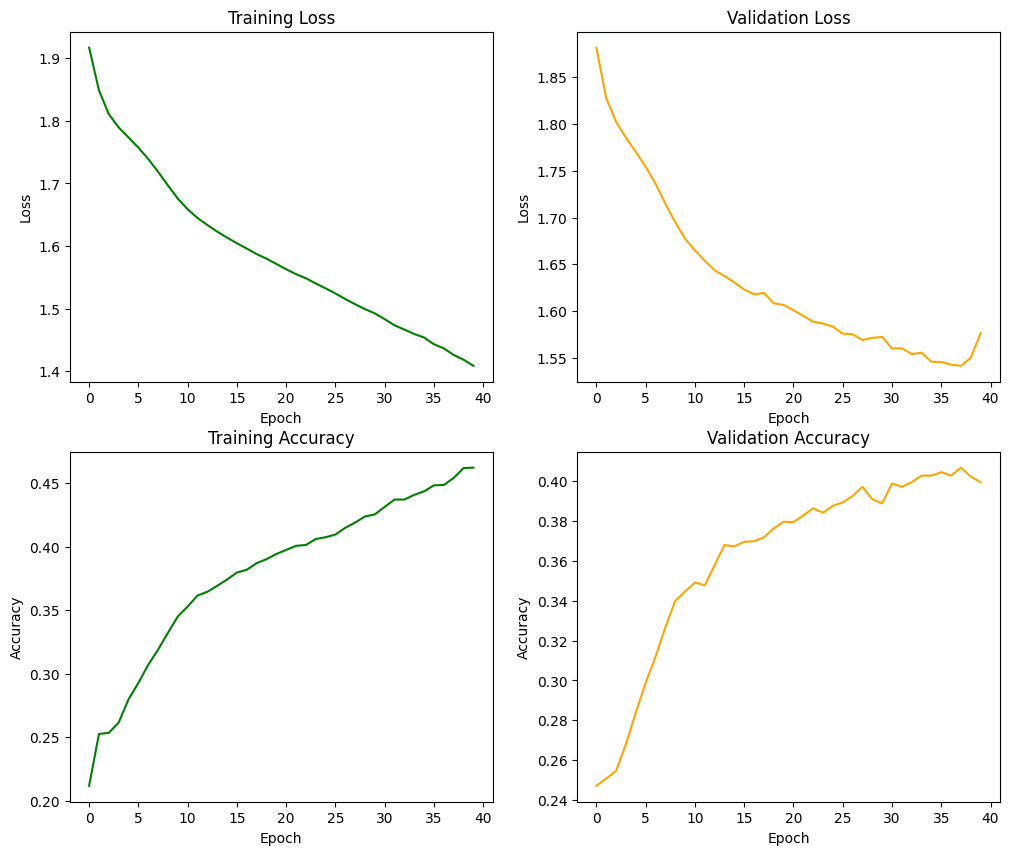

In [133]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()
